In [1]:
import pygame
import csv
import sys

import pandas as pd
import numpy as np

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

point_colors = [ "#C61BCC", "#17B229"]
bg_colors = ["#FFA1F6", "#EAC7E3", "#BADFBA","#B3FFA6"]

pygame 2.5.1 (SDL 2.28.2, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


El siguiente fragmento abre una interfaz de pygame para que crees tu propio dataset en dos dimensiones. Los puntos rosas son los positivos y los verdes los negativos.

In [ ]:
# Configuración inicial
WIDTH, HEIGHT = 600, 600
WINDOW_SIZE = (WIDTH, HEIGHT)
BLACK = (0, 0, 0)
GREEN = (0, 255, 0)
PINK = (255, 105, 180)
POINT_RADIUS = 5
FILENAME = "raw_kernel.csv"

# Inicializar pygame
pygame.init()
screen = pygame.display.set_mode(WINDOW_SIZE)
pygame.display.set_caption("Click para generar puntos")
clock = pygame.time.Clock()

# Lista de puntos: cada uno será (x_normalizado, y_normalizado, etiqueta)
X = []

# Bucle principal
running = True
while running:
    screen.fill(BLACK)

    # DIBUJAR PUNTOS EN CADA STEP DEL PROGRAMA
    for x, y, label in X:
        px = int(x * WIDTH)
        py = int(y * HEIGHT)
        color = PINK if label == 1 else GREEN
        pygame.draw.circle(screen, color, (px, py), POINT_RADIUS)

    pygame.display.flip()

    for event in pygame.event.get():

        # SALIR
        if event.type == pygame.QUIT:
            running = False
            
        # DIBUJAR PUNTOS CUANDO CLIQUES CON EL RATÓN 
        elif event.type == pygame.MOUSEBUTTONDOWN:
            mouse_x, mouse_y = pygame.mouse.get_pos()
            x_norm = mouse_x / WIDTH
            y_norm = mouse_y / HEIGHT

            if event.button == 1:  # Clic izquierdo → verde → etiqueta 1
                X.append((x_norm, y_norm, 1))
            elif event.button == 3:  # Clic derecho → rosa → etiqueta -1
                X.append((x_norm, y_norm, -1))

        # GUARDAR
        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_s:
                with open(FILENAME, "w", newline="") as f:
                    writer = csv.writer(f)
                    writer.writerow(["x", "y", "label"])
                    writer.writerows([[x, 1.0 - y, label] for x, y, label in X])
                print(f"Archivo {FILENAME} guardado.")

    clock.tick(60)

pygame.quit()

Archivo raw_kernel.csv guardado.


Esto coje el csv de antes y lo transforma en un .dat legible por ampl. Al final de esto tendrás las variables X_train, X_test, y_train, y_test

In [ ]:
beta = 50  # 1/(2*sigma^2) del kernel gaussiano

# Leer CSV
df = pd.read_csv(FILENAME)
X = df[['x', 'y']].to_numpy()
y = df['label'].to_numpy()

# Dividir en train/test (90% / 10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
m = len(X_train)

# Definir kernel gaussiano
def gaussian_kernel(xi, xj):
    diff = xi - xj
    return np.exp(-beta * np.dot(diff, diff))

# Construir la matriz K solo con puntos de entrenamiento
K = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        K[i, j] = gaussian_kernel(X_train[i], X_train[j])

# Escribir archivo .dat para AMPL
with open("data_dual_kernel.dat", "w") as f:
    f.write(f"param m := {m};\n\n")

    f.write("param y :=\n")
    for i in range(m):
        f.write(f"{i+1} {int(y_train[i])}\n")
    f.write(";\n\n")

    f.write("param K :\n")
    f.write(" ".join(str(j+1) for j in range(m)) + " :=\n")
    for i in range(m):
        row = " ".join(f"{K[i, j]:.6f}" for j in range(m))
        f.write(f"{i+1} {row}\n")
    f.write(";\n")

print("Archivo AMPL creado con datos de entrenamiento: data_dual_kernel.dat")
print(f"Tamaño de entrenamiento: {m}")
print(f"Tamaño de test: {len(X_test)}")



Archivo AMPL creado con datos de entrenamiento: data_dual_kernel.dat
Tamaño de entrenamiento: 23
Tamaño de test: 3


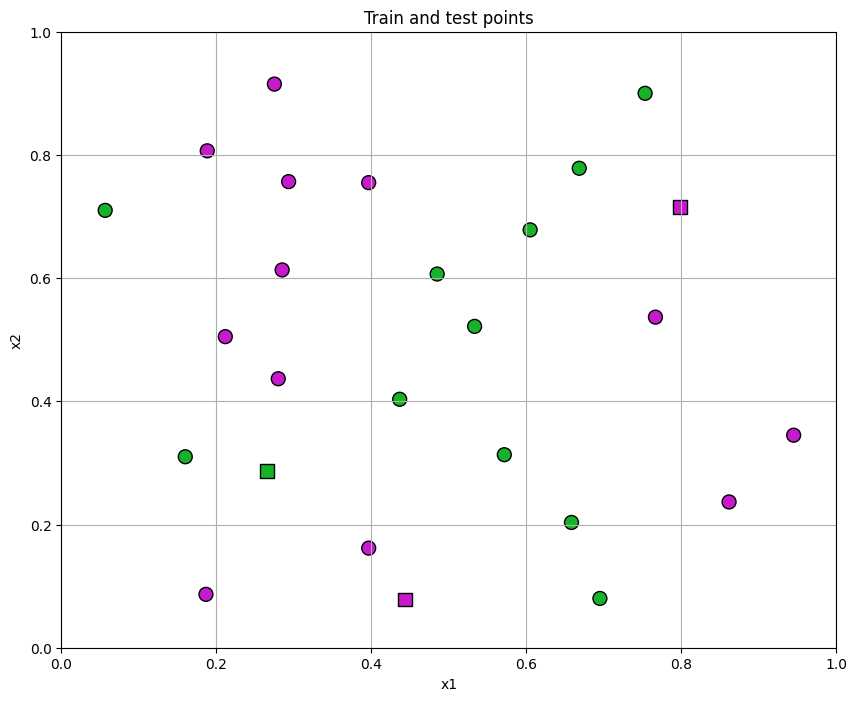

En total hay 26 puntos: Hay 23 de train y 3 de test. 


In [ ]:
def plot_data_points(X_train, y_train, X_test, y_test):
    """
    Versión simplificada que solo dibuja puntos de entrenamiento y prueba.
    - X_train, X_test: Arrays de forma (n_samples, 2).
    - y_train, y_test: Arrays de etiquetas (+1 o -1).
    """
    plt.figure(figsize=(10, 8))
    
    # Colores (rosa para +1, verde para -1)
    colors_train = np.where(y_train == 1,   point_colors[0],  point_colors[1])
    colors_test = np.where(y_test == 1,     point_colors[0],  point_colors[1]) 
    
    # Dibujar puntos de entrenamiento (círculos)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=colors_train, 
                edgecolor='k', s=100, label='Train', marker='o')
    
    # Dibujar puntos de prueba (cuadrados)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=colors_test, 
                edgecolor='k', s=100, label='Test', marker='s')
    
    # Ajustes del gráfico
    plt.title("Train and test points")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

    print(f"En total hay {len(X_test)+len(X_train)} puntos: Hay {len(X_train)} de train y {len(X_test)} de test. ")

plot_data_points(X_train, y_train, X_test, y_test)

Ahora ejecutas "svm_dual.run" en ampl para obtener "resultados_svm_dual.txt". Ahí estará el valor de las lambdas, que debes copiar y pegar aquí: 

In [5]:

lambdas = [0.953935, 0.581570, 1.000000, 0.893611, 0.598355, 1.000000, 0.914439, 0.899516, 0.510490, 0.660277, 0.088137, 0.258632, 1.000000, 0.840013, 0.536206, 0.461478, 0.000000, 0.985832, 1.000000, 0.818797, 0.940649, 1.000000, 0.551821, ];




Ahora queremos encontrar el valor de gamma. El siguiente código te dice qué lambdas cumplen 0 < lambda < nu y por tanto representan support vectors. Además, te calcula la gamma para cada uno de ellos y te hace el average. 

In [6]:

m = len(lambdas)
indices = [ i for i in range(m) if lambdas[i] > 0 and lambdas[i] < 1 ]

print( "Los índices son: " + str([i+1 for i in indices]) )

print("A partir de aquí deducimos que la gamma puede valer: ")

mean_gamma = 0


for k in indices: 
    gamma_k = y_train[k] - sum( [  lambdas[i]*y_train[i]*K[i, k] for i in range(m)] )
    print(f"Para el punto {k}, gamma = {gamma_k}")
    mean_gamma += gamma_k

mean_gamma = mean_gamma / len(indices)

print(f"El promedio es {mean_gamma}")

gamma = mean_gamma


len(indices)

Los índices son: [1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 23]
A partir de aquí deducimos que la gamma puede valer: 
Para el punto 0, gamma = 0.09967260999336858
Para el punto 1, gamma = 0.09967355844284942
Para el punto 3, gamma = 0.09967328494741734
Para el punto 4, gamma = 0.09967411202344478
Para el punto 6, gamma = 0.09967325651550718
Para el punto 7, gamma = 0.09967339523552077
Para el punto 8, gamma = 0.09967427281831531
Para el punto 9, gamma = 0.09967132243795418
Para el punto 10, gamma = 0.09967359079088278
Para el punto 11, gamma = 0.09967368112180697
Para el punto 13, gamma = 0.09967310307417188
Para el punto 14, gamma = 0.09967240978637715
Para el punto 15, gamma = 0.09967229238215802
Para el punto 17, gamma = 0.09967180768423833
Para el punto 19, gamma = 0.09967251136422095
Para el punto 20, gamma = 0.09967129276349351
Para el punto 22, gamma = 0.09967245769175315
El promedio es 0.09967287994549884


17

El siguiente código define la función f, que dice si un punto es de un tipo o de otro. Posteriormente hace un gráfico con matplot donde dibuja los puntos iniciales y de fondo pinta de verde claro las zonas donde f>1, rosa donde f<-1, verde muy claro donde f in [0, 1] y rosa muy claro donde f in [-1, 0].

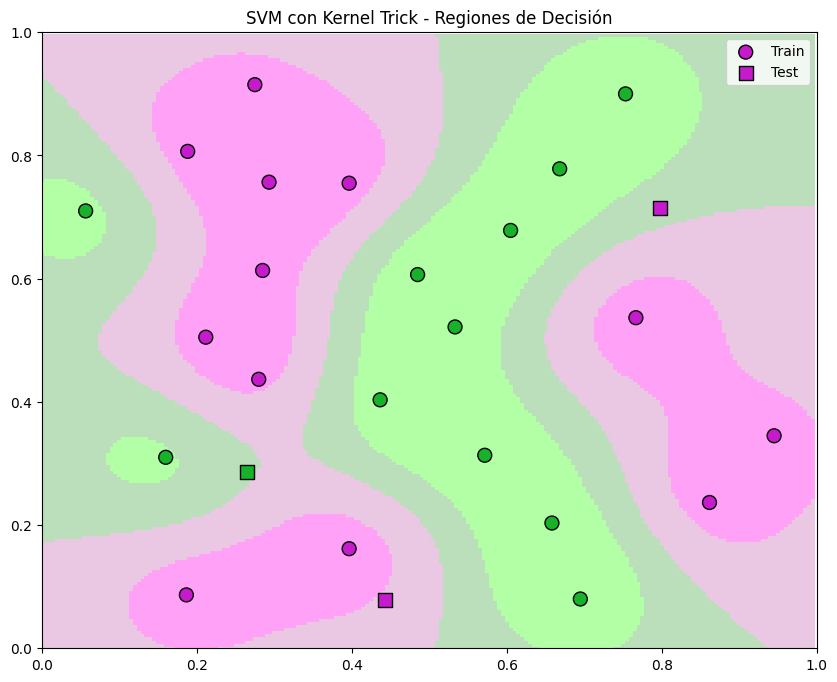

In [ ]:
def f(x: list[float]) -> float:
    return sum([
        lambdas[i] * y_train[i] * gaussian_kernel(X_train[i], x)
        for i in range(m)
    ]) + gamma



def plot_svm_decision_regions(X_train, y_train, X_test, y_test, f, resolution=0.01):
    """
    Parámetros:
    - X_train, y_train: Datos de entrenamiento y sus etiquetas
    - X_test, y_test: Datos de prueba y sus etiquetas
    - f: Función de decisión que toma un punto (x1, x2) y devuelve un valor
    - resolution: Resolución del grid para evaluar la función de decisión
    """
    
    # Configuramos el plot
    plt.figure(figsize=(10, 8))
    
    # Definimos los colores y mapas
    cmap_light = ListedColormap(bg_colors[::-1])
    cmap_bold = ListedColormap(point_colors[::-1])
    
    # Creamos el grid para evaluar la función de decisión
    x1_min, x1_max = 0, 1
    x2_min, x2_max = 0, 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    # Evaluamos la función en cada punto del grid
    Z = np.array([f([x1, x2]) for x1, x2 in zip(xx1.ravel(), xx2.ravel())])
    Z = Z.reshape(xx1.shape)
    
    # Dibujamos las regiones de decisión
    plt.pcolormesh(xx1, xx2, Z, cmap=cmap_light, shading='auto')
    

    # Dibujamos los puntos de entrenamiento (círculos)
    scatter_train = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold,
                                edgecolor='k', s=100, label='Train', marker='o')
    
    # Dibujamos los puntos de prueba (cuadrados)
    scatter_test = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold,
                               edgecolor='k', s=100, label='Test', marker='s')
    
    # Añadimos leyenda y título
    plt.legend(handles=[scatter_train, scatter_test])
    plt.title("SVM con Kernel Trick - Regiones de Decisión")
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    
    plt.show()


plot_svm_decision_regions(X_train, y_train, X_test, y_test, f, 0.005)